In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path = '/content/drive/My Drive/My Dataset'

train_dir = dataset_path + '/train'
test_dir = dataset_path + '/test'

Import required libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

Training data generator with augmentation

In [ ]:
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=15,
zoom_range=0.1,
brightness_range=[0.8, 1.2],
width_shift_range=0.1,
height_shift_range=0.1,
horizontal_flip=True
)

Test data generator with only rescaling

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

Define train and test directories from previous step

In [ ]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH_SIZE,
class_mode='binary',
shuffle=True
)

test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(IMG_HEIGHT, IMG_WIDTH),
batch_size=BATCH_SIZE,
class_mode='binary',
shuffle=False
)

Found 723 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


sample training images (both Pothole and Plain), after preprocessing/augmentation.

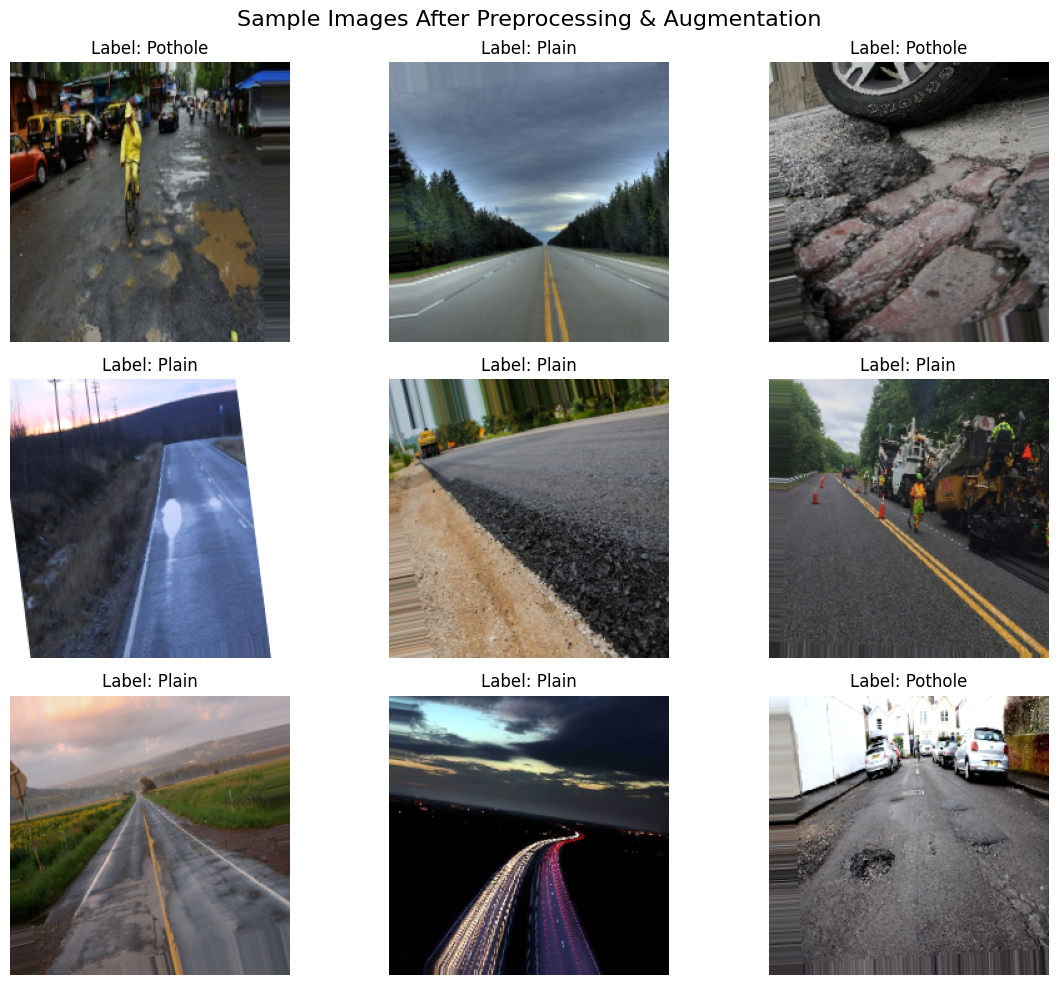

In [ ]:
import matplotlib.pyplot as plt

def show_sample_images(generator):
    class_names = list(generator.class_indices.keys())
    images, labels = next(generator)
    plt.figure(figsize=(12, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Label: {class_names[int(labels[i])].capitalize()}", fontsize=12)
        plt.axis("off")
    plt.suptitle("Sample Images After Preprocessing & Augmentation", fontsize=16)
    plt.tight_layout()
    plt.savefig("/content/figure1_sample_training_images.png")
    plt.show()

show_sample_images(train_generator)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step


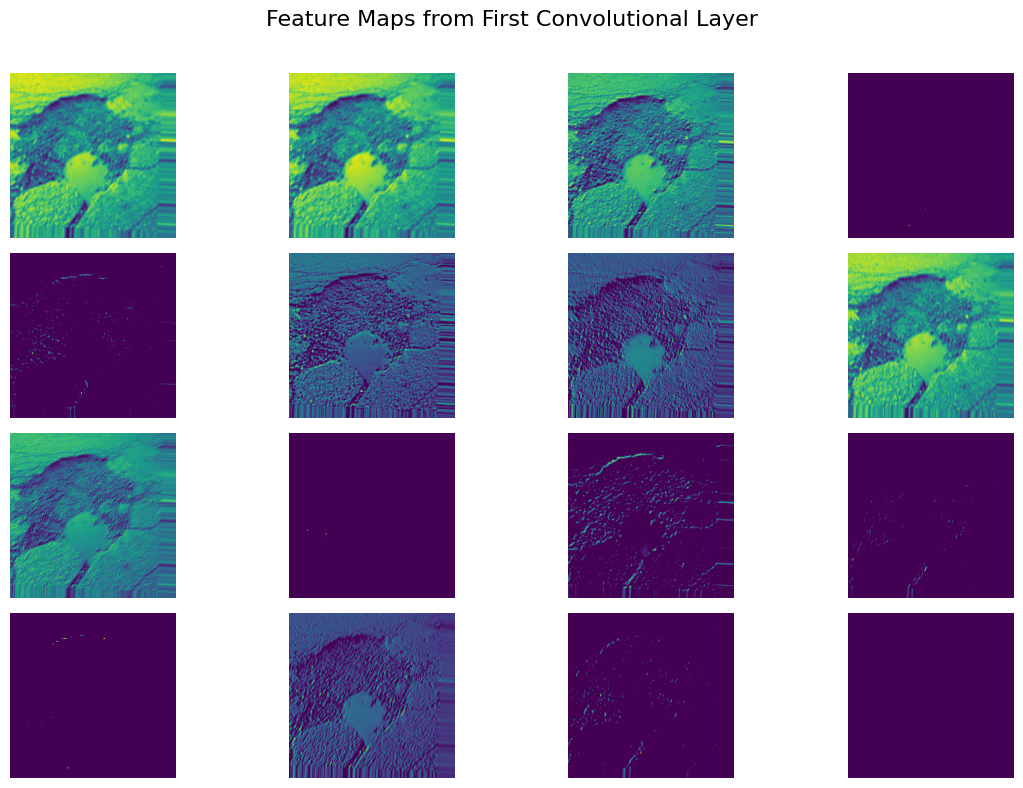

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Get one image from the training set
sample_images, _ = next(train_generator)
img = sample_images[12].reshape(1, 224, 224, 3)

# Run a prediction once to initialize model input/output
_ = model.predict(img)

# Create a model that returns the outputs from convolutional layers
layer_outputs = [layer.output for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)]
activation_model = Model(inputs=model.input, outputs=layer_outputs)

# Get feature maps
feature_maps = activation_model.predict(img)

# Plot the feature maps from the first convolutional layer (layer index 0)
num_maps = 16  # First 16 filters
rows = 4
cols = 4
plt.figure(figsize=(12, 8))  # Larger for high-res figure

for i in range(num_maps):
    ax = plt.subplot(rows, cols, i + 1)
    plt.imshow(feature_maps[0][0, :, :, i], cmap='viridis')
    plt.axis("off")

plt.suptitle("Feature Maps from First Convolutional Layer", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Adjust spacing below title
plt.savefig("/content/feature_maps_visualization.png", dpi=300)  # High-res
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


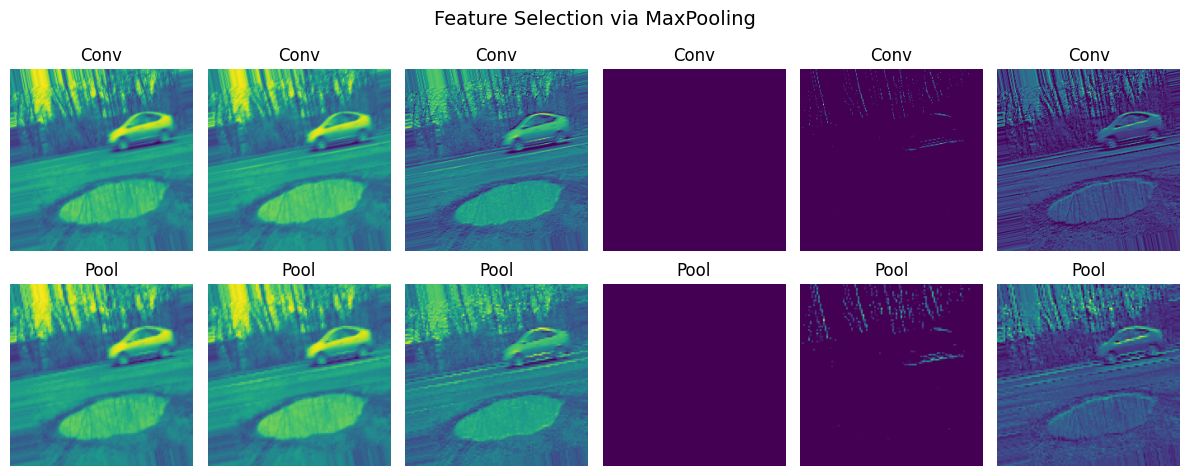

In [ ]:
# Get the actual Conv2D and MaxPooling2D layers
conv_layer = None
pool_layer = None
for layer in model.layers:
    if isinstance(layer, tf.keras.layers.Conv2D) and conv_layer is None:
        conv_layer = layer
    elif isinstance(layer, tf.keras.layers.MaxPooling2D) and pool_layer is None:
        pool_layer = layer

# Build a model that outputs both layers
activation_model = Model(inputs=model.input, outputs=[
    conv_layer.output,     # First Conv2D output
    pool_layer.output      # First MaxPooling2D output
])

# Get one sample image
sample_images, _ = next(train_generator)
img = sample_images[12].reshape(1, 224, 224, 3)

# Predict feature maps
feature_conv, feature_pool = activation_model.predict(img)

# Get number of available filters (just in case it's less than 6)
num_filters = min(6, feature_conv.shape[-1])

# Plot the feature maps
plt.figure(figsize=(12, 5))
for i in range(num_filters):
    # Before pooling
    ax1 = plt.subplot(2, num_filters, i + 1)
    plt.imshow(feature_conv[0, :, :, i], cmap='viridis')
    plt.title("Conv")
    plt.axis("off")

    # After pooling
    ax2 = plt.subplot(2, num_filters, i + 1 + num_filters)
    plt.imshow(feature_pool[0, :, :, i], cmap='viridis')
    plt.title("Pool")
    plt.axis("off")

plt.suptitle("Feature Selection via MaxPooling", fontsize=14)
plt.tight_layout()
plt.savefig("/content/feature_selection_pooling.png")
plt.show()



In [ ]:
# Define CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
## 4. Model Evaluation
# Train the model and record training history
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.6216 - loss: 0.6605 - val_accuracy: 0.6875 - val_loss: 0.6571
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.5913 - loss: 0.6755 - val_accuracy: 0.6875 - val_loss: 0.6527
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.5834 - loss: 0.6721 - val_accuracy: 0.6250 - val_loss: 0.6505
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.6152 - loss: 0.6617 - val_accuracy: 0.6875 - val_loss: 0.6488
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 138s 6s/step - accuracy: 0.6515 - loss: 0.6531 - val_accuracy: 0.7500 - val_loss: 0.6470
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.6391 - loss: 0.6551 - val_accuracy: 0.6875 - val_loss: 0.6501
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - accuracy: 0.6325 - loss: 0.6453 - val_accuracy: 0.5000 - val_loss: 0.6575
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.6321 - loss: 0.6554 - val_accuracy: 0.6875 - v

In [ ]:
# Get predictions
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Classification metrics
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Confusion Matrix:
 [[6 2]
 [2 6]]
Classification Report:
               precision    recall  f1-score   support

       Plain       0.75      0.75      0.75         8
     Pothole       0.75      0.75      0.75         8

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16



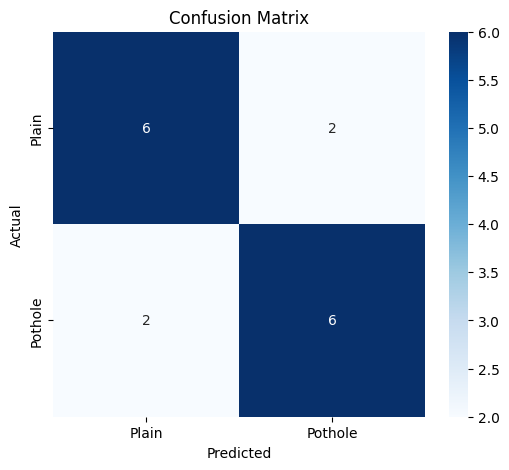

In [ ]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("/content/confusion_matrix.png", dpi=300)
plt.show()

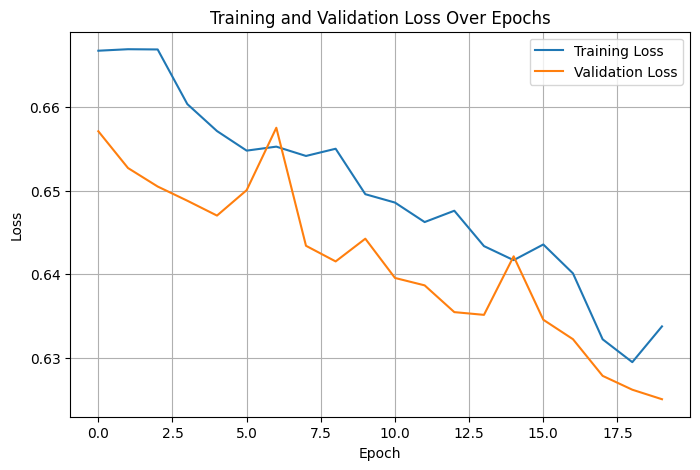

In [ ]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("/content/training_loss_plot.png", dpi=300)
plt.show()

In [ ]:
# 3. Classification Model (Using ResNet50)
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 base model with pretrained weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Print summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,850,113 (90.98 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:

# 4. Model Evaluation
# Train the model and record training history
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=5
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/5
 6/23 ━━━━━━━━━━━━━━━━━━━━ 1:40 6s/step - accuracy: 0.6988 - loss: 0.6140

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.7005 - loss: 0.6167 - val_accuracy: 0.6875 - val_loss: 0.6088
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.6965 - loss: 0.6197 - val_accuracy: 0.6875 - val_loss: 0.6077
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - accuracy: 0.7078 - loss: 0.6187 - val_accuracy: 0.7500 - val_loss: 0.6107
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 6s/step - accuracy: 0.6966 - loss: 0.6098 - val_accuracy: 0.6875 - val_loss: 0.6136
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - accuracy: 0.7013 - loss: 0.6061 - val_accuracy: 0.6875 - val_loss: 0.6115
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6875 - loss: 0.6115
Test Accuracy: 0.6875


In [ ]:

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).reshape(-1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Confusion Matrix:
 [[4 4]
 [1 7]]


In [ ]:
# Classification metrics
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       Plain       0.80      0.50      0.62         8
     Pothole       0.64      0.88      0.74         8

    accuracy                           0.69        16
   macro avg       0.72      0.69      0.68        16
weighted avg       0.72      0.69      0.68        16



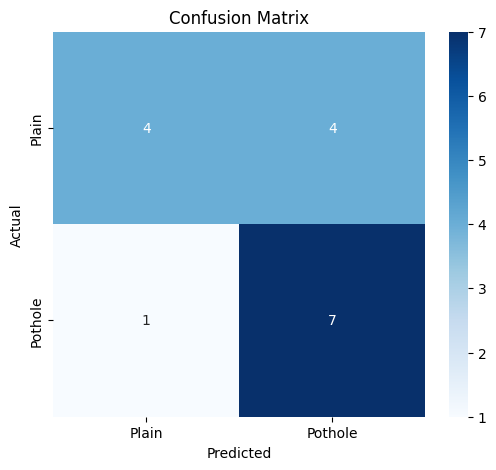

In [ ]:
# Plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig("/content/confusion_matrix.png", dpi=300)
plt.show()

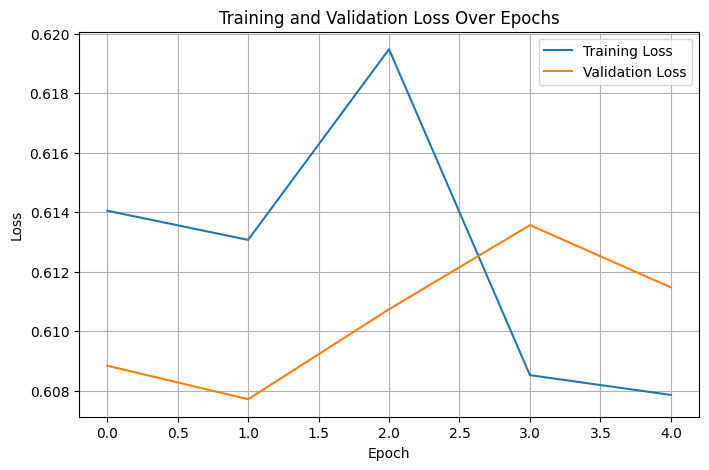

In [ ]:
# Plot training and validation loss over epochs
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("/content/training_loss_plot.png", dpi=300)
plt.show()